# Extracting Sinkholes from Aerial Imagery

## Table of Contents

* [1. Introduction](#1)
* [2. Export Training Data](#2)
    * [2.1 Import ArcGIS API for Python and get connected to your GIS](#3) 
    * [2.2 Get data that will be used for data export](#4)
    * [2.3 Export training data](#5)
* [3. Training the MaskRCNN model](#6)
    * [3.1 Necessary Imports](#7)  
    * [3.2 Prepare Data](#8)
    * [3.3 Visualise Training Data](#9)
    * [3.4 Load a MaskRCNN model](#10)
    * [3.5 Find an Ideal Learning Rate](#11)
    * [3.6 Train the model](#12)
    * [3.7 Save the model](#13)
    * [3.8 Load a trained model for further training](#14)
    * [3.9 Visualise Validation Results](#15)
* [4. Model Deployment and Inferencing](#16)
* [5. Conclusion](#17)

## 1. Introduction <a class="anchor" id="1"></a>

Due to the partial diversion of Jordan River away from the Dead sea, water level of the sea has declined since the past few decades. When sea water decreases, freshwater from aquifers tries to replace it. However, areas beneath the shoreline has brine layer (high concentration salt water) which also dissolves with fresh water causing underground cavities. The surface above these cavities collapses due to lack of support resulting in sinkholes. 

According to the article Dead Sea Sinkholes, 2019, (put link) an aerial survey was conducted in 2008 over a 60 km long and 1 km wide strip along the western coast of Dead Sea. The survey shows that the western coast has approximately 2500 such sinkholes. This sample will detect sinkholes over the western coast of Dead Sea and find out their spatial distribution.

The notebook shows ArcGIS API for Python capabilities to train a deep learning model and extract the sinkholes from aerial imagery of Dead Sea. The aerial imagery used in the notebook is from Ofek Aerial Photography (https://www.ofek-air.com/en/ ). The spatial resolution of the aerial imagery is 10cm. 

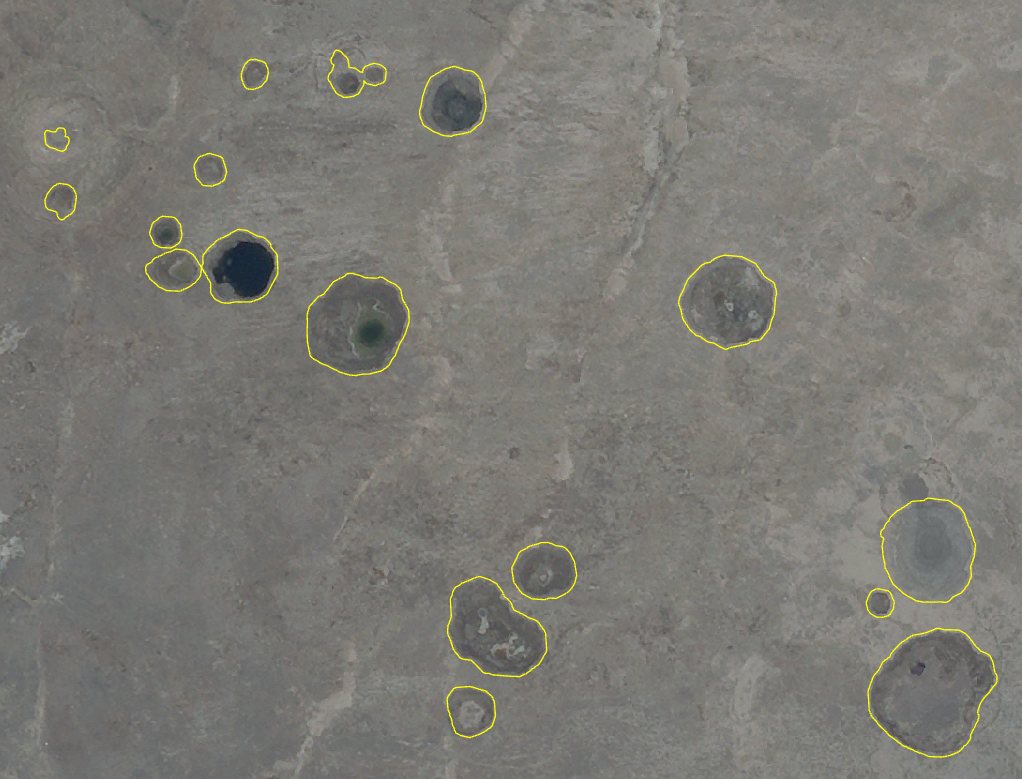

<center> Fig. 1.1: Training data of Sinkholes overlayed on Ofek aerial imagery <center>

This sample has three sections: -

* Export training data for deep learning model

* Train the model

* Model Deployment and Inferencing

## 2. Export Training Data<a class="anchor" id="2"></a>

In this sample the data was exported in ArcGIS Pro and MaskRCNN model has been used for extracting the sinkholes from the aerial imagery. The training data for deep learning model can be exported by both ArcGIS Pro and ArcGIS Enterprise platform using [Export Training Data for Deep Learning](https://developers.arcgis.com/rest/services-reference/export-training-data-for-deep-learning.htm) tool. 

### 2.1 Import ArcGIS API for Python and get connected to your GIS<a class="anchor" id="3"></a>

In [1]:
from arcgis.gis import GIS
gis = GIS("https://datascienceadv.esri.com/portal", "portaladmin", "Roll.Tide2019", verify_cert=False)

### 2.2 Get data that will be used for data export<a class="anchor" id="4"></a>

Get the feature class that defines the location and label of each sinkhole. To avoid false predictions the feature class has two classes 1= sinkholes and 2= false negatives i.e. trees, buildings, etc.

<Item title:"sinkhole_polygons" type:Feature Layer Collection owner:api_data_owner>
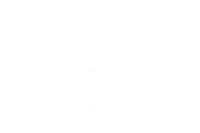

In [2]:
sinkhole_labels = gis.content.search("sinkhole_polygons", item_type='Feature Layer Collection')[0]
sinkhole_labels

<Item title:"ofek_aerial_imagery_for_deadsea_israel" type:Service Definition owner:portaladmin>
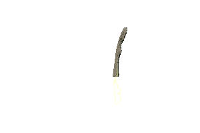

In [2]:
ofek_imagery = gis.content.search("ofek_aerial_imagery_for_deadsea")[0]
ofek_imagery

### 2.3 Export training data<a class="anchor" id="5"></a>

Export Training Data For Deep Learning tool is one of the Geoprocessing tool of ArcGIS.

* In `Input Raster` select the 'Ofek aerial imagery'

* In `Output Folder` define the folder where the training data will be exported, it can be a new folder or an existing folder.

* In `Input Feature Or Classified Raster` set the sinkhole samples feature class.

* In `Image Format` select the format in which the trsining chips will be exported. In this sample 'TIFF' was selected.

* Both `Tile Size X` and `Tile Size Y` were set as '400' pixel.

* `Stride` was set as '128' pixel.

* In `Meta Data Format` select 'RCNN Mask'.

In Environments tab

* In `Extent` select the feature class or leave it as 'Default'.

* As spatial resolution of aerial imagery is 10 cm, Set the `Cell Size` as '0.1' because the coordinate system is in meters. 



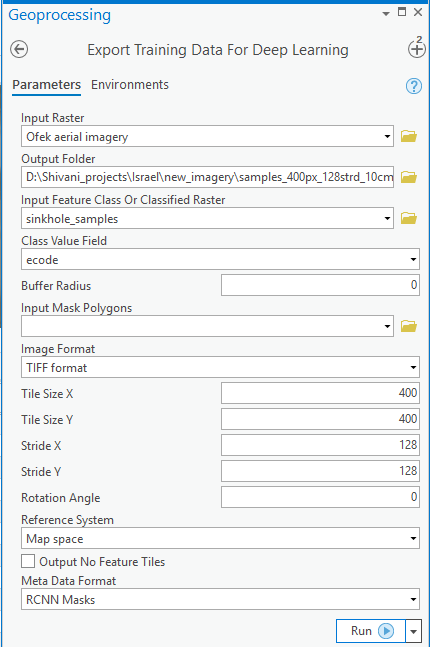 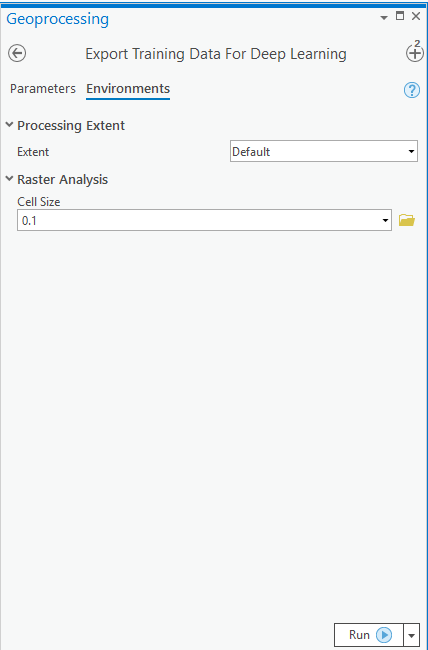

<center> Fig. 2.1: Parameters of Export Training Data For Deep Learning tool <center>


The training data can also be exported in Jupyter notebook using the following arcpy code:

In [4]:
arcpy.ia.ExportTrainingDataForDeepLearning("yosh_2019", r"D:\Shivani_projects\Israel\new_imagery\samples_400px_128strd_10cm",
                                           "newimg_sinkhole", "TIFF", 400, 400, 128, 128, "ONLY_TILES_WITH_FEATURES",
                                           "RCNN_Masks", 0, "ecode", 0, None, 0, "MAP_SPACE", "PROCESS_AS_MOSAICKED_IMAGE", "NO_BLACKEN", "FIXED_SIZE")

## 3. Training the MaskRCNN model<a class="anchor" id="6"></a>

[MaskRCNN](https://arxiv.org/pdf/1703.06870.pdf) is an instance segmentation model which correctly detects object with precise mask of each instance. This model covers goals of both object detection and segmentation.

The model will be trained using Jupyter notebook, detailed documentation about environment installation and setup is available [here](https://developers.arcgis.com/python/guide/install-and-set-up/)


### 3.1 Necessary Imports<a class="anchor" id="7"></a>

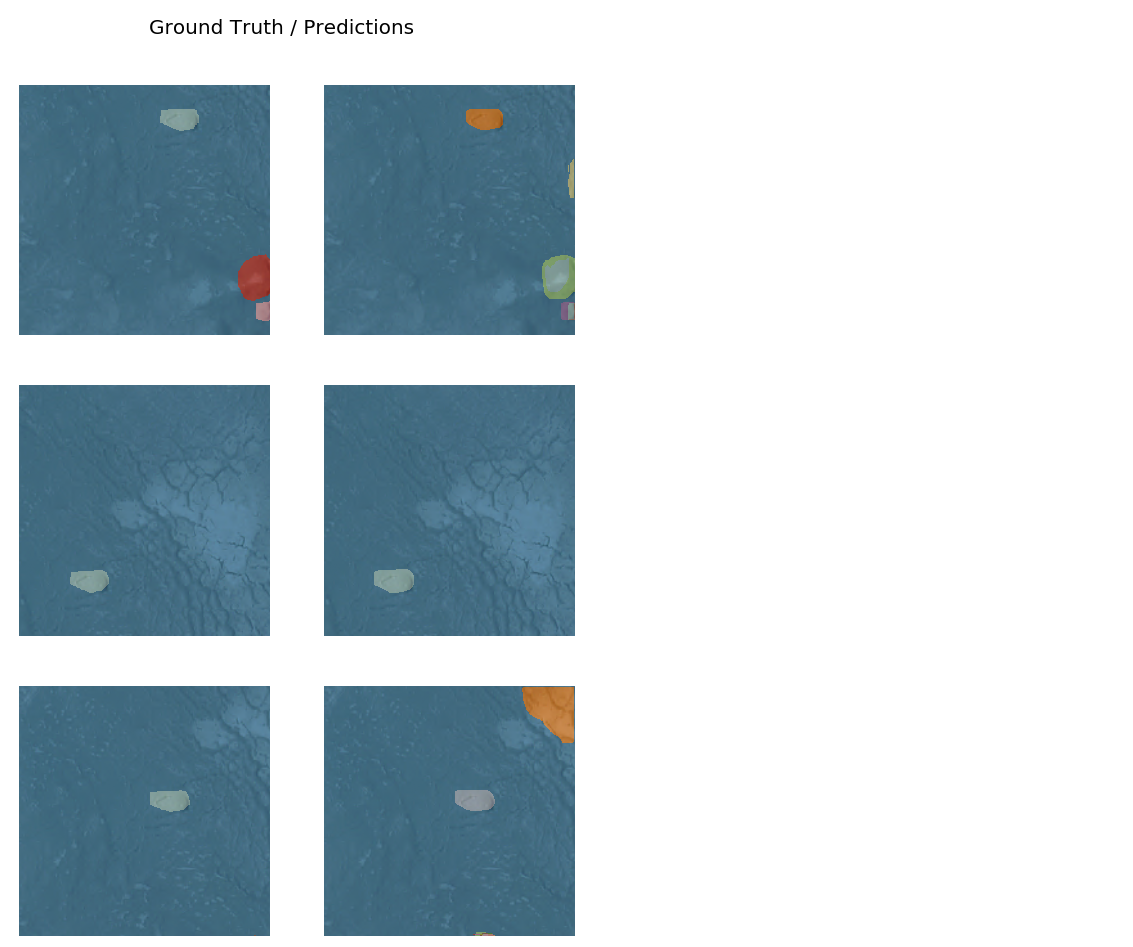

In [5]:
# ArcGIS api imports 
from arcgis.learn import MaskRCNN, prepare_data


### 3.2 Prepare Data<a class="anchor" id="8"></a>

This step includes defining the path of the training data and other parameters.

`path`: - path of the folder having exported training data

`batch_size`: - Number of images used in each step of the epoch for training the model 

`chip_size`: - Size of the chip used in trsining the model

In [6]:
# Create Databunch
data = prepare_data(path=r'/home/administrator/israel_sinkholes/samples_400px_128strd_10cm',
                    batch_size=16,
                    chip_size=256)

### 3.3 Visualise Training Data<a class="anchor" id="9"></a>

The exported data can be visualised in Jupyter Notebook similar to ArcGIS Pro.

`rows`: Number of rows in which data will be visualised

`alpha`:  Associates with the opacity of labels overlayed on the aerial imagery

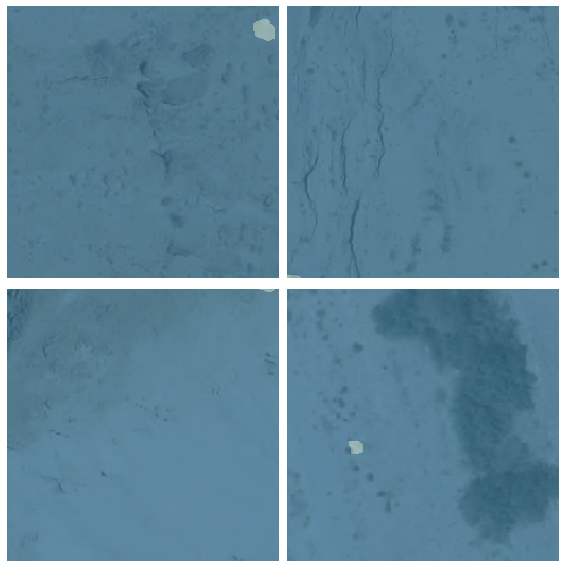

In [7]:
data.show_batch(rows=2, alpha=0.5)

### 3.4 Load a `MaskRCNN` model<a class="anchor" id="10"></a>

MaskRCNN is an instance segmentation model used for image classification. The model can be created by using the following code.

In [8]:
# Create MaskRCNN Model
model = MaskRCNN(data)

In [9]:
model.load("D:\\Shivani_projects\\Israel\\new_imagery\\samples_400px_128strd_10cm_inferenced2c_1nov\\models\\maskrcnn_israel_50e_4nov")

### 3.5 Find an Ideal Learning Rate<a class="anchor" id="11"></a>

In the process of training a deep learning model, learning rate is one of the important hyperparameters. Selecting a small learning rate may result in slow model training, however, too high value can cause overshoot of minima at low error rate. `model.lr_find ()` can be used for finding ideal learning rate for the model.

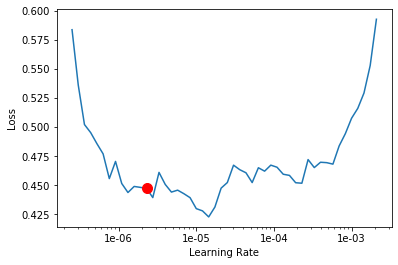

2.2908676527677735e-06

In [10]:
# Find Learning Rate
model.lr_find()

`model.lr_find()` method gives a learning rate value which can be used for training the model or the learning rate can be specified with the help of graph. In the current sample 2.29e-06 or 0.000002 was used as learning rate for training the model.  

### 3.6 Train the model<a class="anchor" id="12"></a>

The cycle of passing each image of training data for training the model is called one epoch. The model was trained for 50 `epoch`. The model was trained using the `fit()` method.

In [11]:
# Training the model
model.fit(50, lr=7.5857e-05)

epoch,train_loss,valid_loss,time
0,0.721826,0.708599,06:32
1,0.625415,0.612227,06:39
2,0.544021,0.544738,06:41
3,0.489154,0.487443,06:49
4,0.433784,0.464495,06:47
5,0.404668,0.420305,06:54
6,0.390258,0.410884,06:52
7,0.345929,0.395708,06:53
8,0.318998,0.394992,06:52
9,0.288693,0.346824,06:55


The training data was divided into two sets, 80% of the data goes into the training set and 20% data remains in validation set. if both training and valdation loss decreases, it indicates that the model is learning well to detect the objects (i.e. sinkholes). 

### 3.7 Save the model<a class="anchor" id="13"></a>

In ArcGIS platform the deep learning model is saved as 'Deep Learning Package or .dplk' format. `save ()` method was used for saving the trained MakRCNN model which can be deployed in ArcGIS Pro or ArcGIS Enterprise.

In [12]:
# Save model to file
model.save("maskrcnn_50e")

WindowsPath('D:/Shivani_projects/Israel/new_imagery/samples_400px_128strd_10cm_inferenced2c_1nov/models/maskrcnn_israel_1e_1nov')

### 3.8 Load a trained model for further training<a class="anchor" id="14"></a>

If the results of the trained model are not satisfactory further training can be done on the saved model using `load()` method.

In [13]:
#Load model from previous saved file
model.load("maskrcnn_50e")

### 3.9 Visualise Validation Results<a class="anchor" id="15"></a>

Both ground truth and predictions of some random chips can be visualised using `show_results` method. 

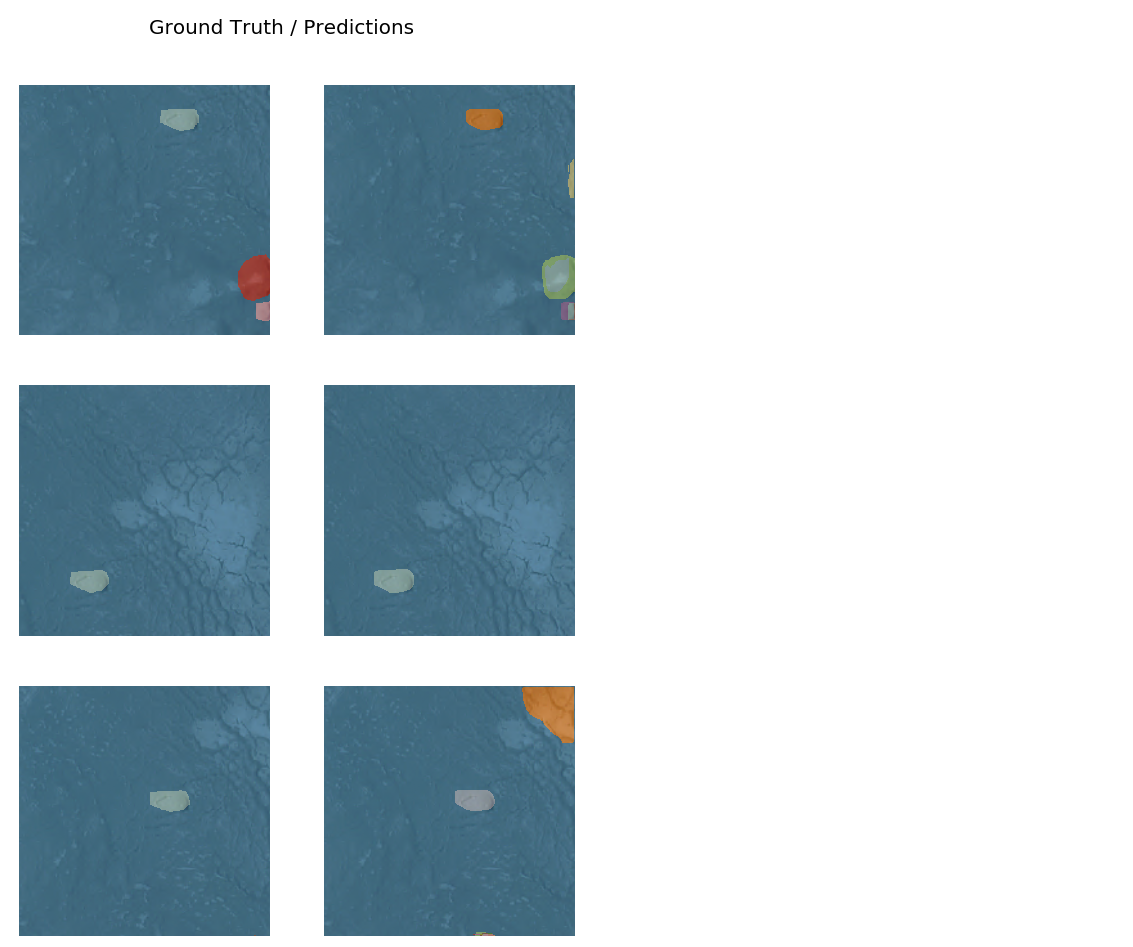

In [14]:
model.show_results(nrows=3)

## 4. Model Deployment and Inferencing<a class="anchor" id="16"></a>

The model which was saved earlier in '.dplk' was used for extracting the sinkholes using Detect Objects Using Deep Learning tool. This tool is available in both [ArcGIS Pro](https://pro.arcgis.com/en/pro-app/tool-reference/raster-analysis/detect-objects-using-deep-learning.htm) and [ArcGIS Enterprise](https://developers.arcgis.com/rest/services-reference/detect-objects-using-deep-learning.htm)

Detect Objects Using Deep Learning tool is one of the Geoprocessing tool.
* `Input Raster`: The raster from which the sinkholes will be extracted. In this sample 'Ofek Aerial Imagery'.
* `Model Definition`: The '.emd' file saved inside the 'models' folder of training data.
* `padding`: Padding allows to add some extra information along the tile edges, this helps the model to predict better.
* `threshold`: The objects which have confidence more than the defined threshold will be shown in the output feature class.
* `return_bboxes`: if it is set as 'True' the bounding box will be drawn over the objects.

In Environement tab
* `Cell Size`: It should be close or equal to the value on which the training data has been exported.
* `Processor Type`: This defines which type of processor will be used CPU or GPU. The tool uses GPU as default.




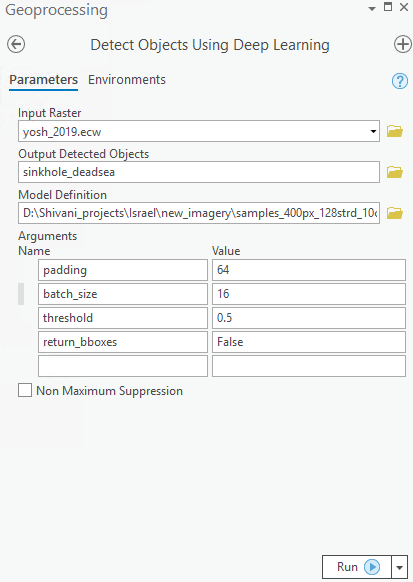 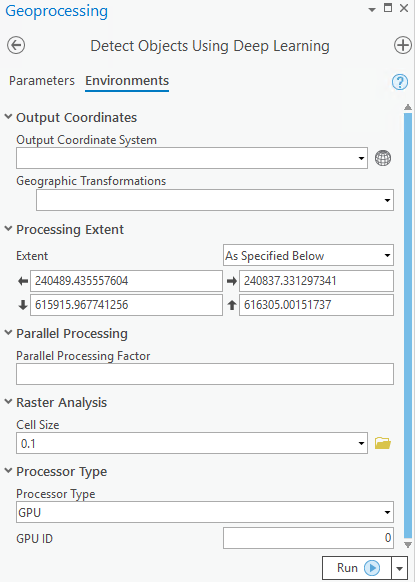

<center> Fig. 4.1: Parameters of Detect Objects Using Deep Learning tool <center>

In [15]:
The results can also be inferenced in Jupyter notebook using the following arcpy code:

In [16]:
arcpy.ia.DetectObjectsUsingDeepLearning("yosh_2019",
                                        r"dead_sea_sinkholes.gdb\sinkholes_israel",
                                        r"..\commondata\maskrcnn_israel_2e_1nov\maskrcnn_israel_2e_1nov.emd","padding 64; batch_size 4;threshold 0.5;return_bboxes False", 
                                        "NO_NMS", 
                                        "Confidence", 
                                        "Class", 
                                        0, 
                                        "PROCESS_AS_MOSAICKED_IMAGE")

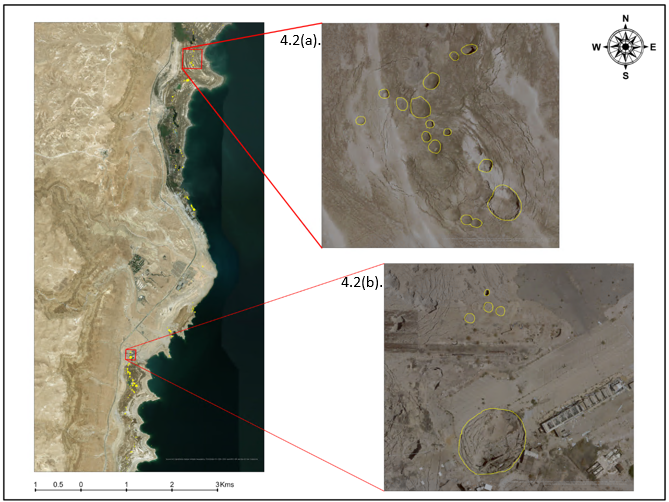

<center> Fig 4.2: Inferenced results for sinkholes over Ofek aerial imagery </center>

Fig 4.2 is showing the distribution of sinkholes over the western coast of Dead sea. From the results it can be interpreted that mostly, the sinkholes appears in a cluster.The size of sinkholes varies from 0.3 sq. m to 3 sq. km. In Fig. 4.2(b) a large sinkhole can be seen near settlement which can be a threat to life for the people living near it.   

## 5. Conclusion<a class="anchor" id="17"></a>

In this notebook, a new deep learning model MaskRCNN has been used for extracting sinkholes from Ofek aerial imagery of Dead sea's western coast. In the sample the process of exporting data for MaskRCNN using ArcGIS Pro and ArcGIS python API has been discussed. After that the steps of preparing the training data, training the model, saving and loading the model and  visualizing the results have been explained. Then the process of deployment and inferencing of results using `ArcGIS Pro` &  `ArcGIS Enterprises` has been explained.
The model was able to extract the sinkholes in the original shape. From the results it can be concluded that most of the sinkholes lies in the buffer zone of 2km from the coastline. The same workflow can be used for different use cases. For example, the building footprints can be extracted accurately in the areas where the buildings are densely built using MaskRCNN where UNet doesn't performs well.